In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from gPhoton.galextools import mag2counts
plt.rcParams.update({'font.size': 18})

In [2]:
# Import the function definitions that accompany this notebook tutorial.
nb_funcdef_file = "function_defs.py"
if os.path.isfile(nb_funcdef_file):
    from function_defs import get_inff, calculate_flare_energy, refine_flare_ranges
else:
    raise IOError("Could not find function definition file '" + nb_funcdef_file + "' that goes with this notebook.")

In [3]:
# Import the function definitions that accompany this notebook tutorial.
nb_recoverydef_file = "recovery_defs.py"
if os.path.isfile(nb_recoverydef_file):
    from recovery_defs import fake_a_flare, calculate_ideal_flare_energy, inject_and_recover, run_full_inj
else:
    raise IOError("Could not find recovery definition file '" + nb_recoverydef_file + "' that goes with this notebook.")

In [4]:
# Restore the distance parameter.  Note: this assumes you've run the "generate_products" notebook already.  If not you
# will need to specify the distance to use.
#%store -r distance
# If you have not run the "generate_products" notebook during this session, uncomment the line below and specify
# the distance to the system in parsecs.
distance = 1/(372.1631/1000) # parsecs

In [5]:
# Define some parameters for our recovery tests.
band = 'NUV'
binsize = 30.
quiescent_mag = 18. # approx. NUV mag of UV Ceti
trange = [0., 1600.] # nominal GALEX visit start and end, in seconds
resolution = 0.05 # photon time resolution in seconds
detection_threshold = 3. # min. detection threshold allowed for a flare to be considered "detected", measured in sigma
max_flares_pervisit = 3 # max. number of flares to occur within a given Visit

Let's generate some synthetic flares and compare the energies measured by our flare finding algorithm with the known
values.  This is to demonstrate what a few of the synthetic flares look like and what the fits to them look like. The full simulation is done later.

In [6]:
# Now we'll do a big run (we won't make any plots though.)
# On a Macbook Pro this takes about 1.5 hours to run to completion for 100,000 flare lightcurves.
run_inj = False
if run_inj:
    start_time = time.time()
    random_seed = 42 # So that the exact results here when selecting random flare properties are repeatable.
    rng = np.random.default_rng(seed=random_seed)
    # How many flares to simulate.
    n_flares_to_make = 100000
    (all_n_in_visit, all_n_det, all_n_det_wrongenergy, all_n_miss, all_n_fp,
     all_injected_flare_energies_n1, all_injected_flare_energies_n2,
     all_injected_flare_energies_n3, all_detected_flare_energies_n1,
     all_detected_flare_energies_n2, all_detected_flare_energies_n3) = run_full_inj(n_flares_to_make,
                                                                                    rng, band, binsize,
                                                                                    max_flares_pervisit,
                                                                                    trange, resolution,
                                                                                    detection_threshold,
                                                                                    quiescent_mag, distance)
    end_time = time.time()
    print("Time taken to finish: " + str(end_time - start_time))
    # Save results for re-use later to avoid having to re-run the full injection.
    %store all_n_in_visit
    %store all_n_det
    %store all_n_det_wrongenergy
    %store all_n_miss
    %store all_n_fp
    %store all_injected_flare_energies_n1
    %store all_injected_flare_energies_n2
    %store all_injected_flare_energies_n3
    %store all_detected_flare_energies_n1
    %store all_detected_flare_energies_n2
    %store all_detected_flare_energies_n3
else:
    %store -r all_n_in_visit
    %store -r all_n_det
    %store -r all_n_det_wrongenergy
    %store -r all_n_miss
    %store -r all_n_fp
    %store -r all_injected_flare_energies_n1
    %store -r all_injected_flare_energies_n2
    %store -r all_injected_flare_energies_n3
    %store -r all_detected_flare_energies_n1
    %store -r all_detected_flare_energies_n2
    %store -r all_detected_flare_energies_n3

Flares Inj  | Total: N_DET, N_DET_WRONG_ENERGY, N_NISS, N_FP
N inj = 1| 33316 flares: 31405, 0, 1911, 1015
N inj = 2| 66324 flares: 28781, 7539, 30004, 6533
N inj = 3| 100566 flares: 25693, 11435, 63438, 4494


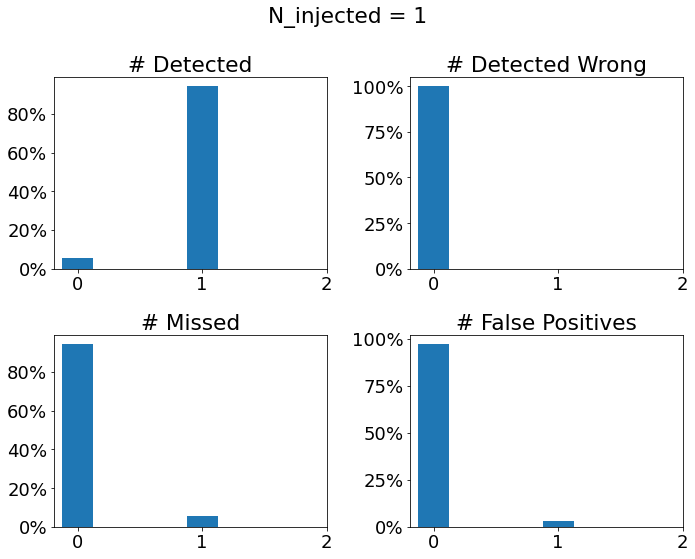

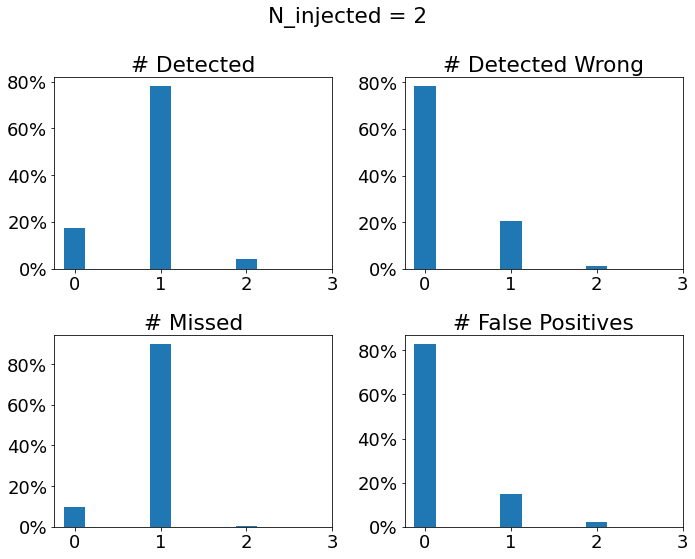

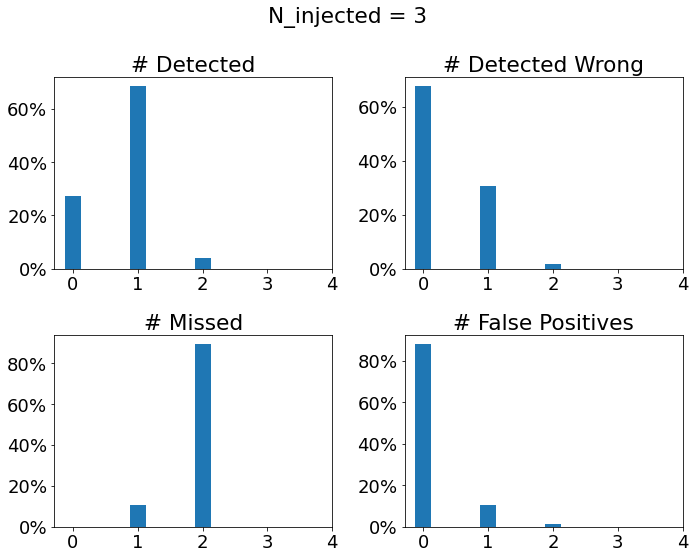

In [7]:
# Plot up a summary of the statistics for each of the light curves, sorted by number of flares injected.
print("Flares Inj  | Total: N_DET, N_DET_WRONG_ENERGY, N_NISS, N_FP")
for i in range(3):
    # Look for those light curves with this many injected flares (1, 2, or 3).
    n_inj_flares = i+1
    where_n_flares = np.where(all_n_in_visit == n_inj_flares)[0]
    these_n_det = all_n_det[where_n_flares]
    these_n_det_wrongenergy = all_n_det_wrongenergy[where_n_flares]
    these_n_miss = all_n_miss[where_n_flares]
    these_n_fp = all_n_fp[where_n_flares]
    print("N inj = " + str(n_inj_flares) + '| ' + str(n_inj_flares * len(where_n_flares)) + ' flares: ' + str(sum(these_n_det)) + ', ' +
          str(sum(these_n_det_wrongenergy)) + ', ' + str(sum(these_n_miss)) + ', '  +
          str(sum(these_n_fp)))
    fig, (ax_row1, ax_row2) = plt.subplots(2, 2, figsize=(10, 8))

    # Plot distribution of number of flares detected.
    ax_row1[0].set_title("# Detected")
    ax_row1[0].hist(these_n_det, bins=range(n_inj_flares+2), density=True, align='left', rwidth=0.25)
    ax_row1[0].set_xticks(range(n_inj_flares+2))
    ax_row1[0].yaxis.set_major_formatter(PercentFormatter(1))

    # Plot distribution of number of flares detected.
    ax_row1[1].set_title("# Detected Wrong")
    ax_row1[1].hist(these_n_det_wrongenergy, bins=range(n_inj_flares+2), density=True, align='left', rwidth=0.25)
    ax_row1[1].set_xticks(range(n_inj_flares+2))
    ax_row1[1].yaxis.set_major_formatter(PercentFormatter(1))
    
    # Plot distribution of number of flares missed.
    ax_row2[0].set_title("# Missed")
    ax_row2[0].hist(these_n_miss, bins=range(n_inj_flares+2), density=True, align='left', rwidth=0.25)
    ax_row2[0].set_xticks(range(n_inj_flares+2))
    ax_row2[0].yaxis.set_major_formatter(PercentFormatter(1))
    
    # Plot distribution of number of false positive detections.
    ax_row2[1].set_title("# False Positives")
    ax_row2[1].hist(these_n_fp, bins=range(n_inj_flares+2), density=True, align='left', rwidth=0.25)
    ax_row2[1].set_xticks(range(n_inj_flares+2))
    ax_row2[1].yaxis.set_major_formatter(PercentFormatter(1))
    
    fig.suptitle("N_injected = " + str(n_inj_flares))
    fig.tight_layout()

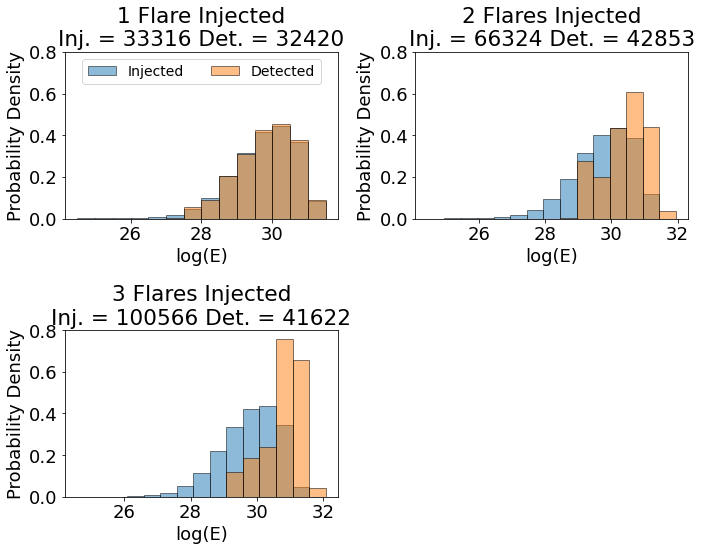

In [8]:
# Plot histograms comparing the injected and detected energies for the cases of 1, 2, and 3
# injected flares.
fig, (ax_row1, ax_row2) = plt.subplots(2, 2, figsize=(10, 8))

# Setup histogram bins, grouped by log10(E).
energy_binstep = 0.5
energy_bins_n1 = np.arange(
    min([min(all_injected_flare_energies_n1), min(all_detected_flare_energies_n1)]),
    max([max(all_injected_flare_energies_n1), max(all_detected_flare_energies_n1)]) + energy_binstep,
    energy_binstep)
energy_bins_n2 = np.arange(
    min([min(all_injected_flare_energies_n2), min(all_detected_flare_energies_n2)]),
    max([max(all_injected_flare_energies_n2), max(all_detected_flare_energies_n2)]) + energy_binstep,
    energy_binstep)
energy_bins_n3 = np.arange(
    min([min(all_injected_flare_energies_n3), min(all_detected_flare_energies_n3)]),
    max([max(all_injected_flare_energies_n3), max(all_detected_flare_energies_n3)]) + energy_binstep,
    energy_binstep)

# Cases of a single inected flare.
ax_row1[0].set_title("1 Flare Injected\nInj. = " + str(len(all_injected_flare_energies_n1)) +
                    " Det. = " + str(len(all_detected_flare_energies_n1)))
ax_row1[0].hist(all_injected_flare_energies_n1, bins=energy_bins_n1, density=True, align='left', rwidth=1.0,
                alpha=0.5, label="Injected", edgecolor="black")
ax_row1[0].hist(all_detected_flare_energies_n1, bins=energy_bins_n1, density=True, align='left', rwidth=1.0,
               alpha=0.5, label="Detected", edgecolor="black")
ax_row1[0].set_xlabel("log(E)")
ax_row1[0].set_ylabel("Probability Density")
ax_row1[0].set_ylim(0., 0.8)
#ax_row1[0].legend(loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.3, 0.0, 0.5))
ax_row1[0].legend(loc="upper center", ncol=2, prop={'size': 14})

# Cases of two inected flares.
ax_row1[1].set_title("2 Flares Injected\nInj. = " + str(len(all_injected_flare_energies_n2)) +
                    " Det. = " + str(len(all_detected_flare_energies_n2)))
ax_row1[1].hist(all_injected_flare_energies_n2, bins=energy_bins_n2, density=True, align='left', rwidth=1.0,
                alpha=0.5, edgecolor="black")
ax_row1[1].hist(all_detected_flare_energies_n2, bins=energy_bins_n2, density=True, align='left', rwidth=1.0,
               alpha=0.5, edgecolor="black")
ax_row1[1].set_xlabel("log(E)")
ax_row1[1].set_ylabel("Probability Density")
ax_row1[1].set_ylim(0., 0.8)

# Cases of three inected flares.
ax_row2[0].set_title("3 Flares Injected\nInj. = " + str(len(all_injected_flare_energies_n3)) +
                    " Det. = " + str(len(all_detected_flare_energies_n3)))
ax_row2[0].hist(all_injected_flare_energies_n3, bins=energy_bins_n3, density=True, align='left', rwidth=1.0,
                alpha=0.5, edgecolor="black")
ax_row2[0].hist(all_detected_flare_energies_n3, bins=energy_bins_n3, density=True, align='left', rwidth=1.0,
               alpha=0.5, edgecolor="black")
ax_row2[0].set_xlabel("log(E)")
ax_row2[0].set_ylabel("Probability Density")
ax_row2[0].set_ylim(0., 0.8)

ax_row2[1].axis("off")
fig.tight_layout()
plt.savefig("figures/inj_det.pdf")